## Demonstration of scNiche on the mouse spleen CODEX data

In this tutorial, we will show you the batch training strategy of scNiche, which enables scNiche to scale to large spatial omics datasets containing hundreds of thousands of cells.
The [mouse spleen CODEX dataset (*Cell, 2018*)](https://doi.org/10.1016/j.cell.2018.07.010) from the wild-type spleen sample (BALBc-1) contains over 80,000 cells.

In [1]:
import scniche as sn
import scanpy as sc
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Last run with scNiche version:", sn.__version__)

# set seed
sn.pp.set_seed()

/slurm/home/yrd/fanlab/qianjingyang/.conda/envs/test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Last run with scNiche version: 1.0.0


[<AxesSubplot: title={'center': 'CellType'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot: title={'center': 'Compartment'}, xlabel='spatial1', ylabel='spatial2'>]

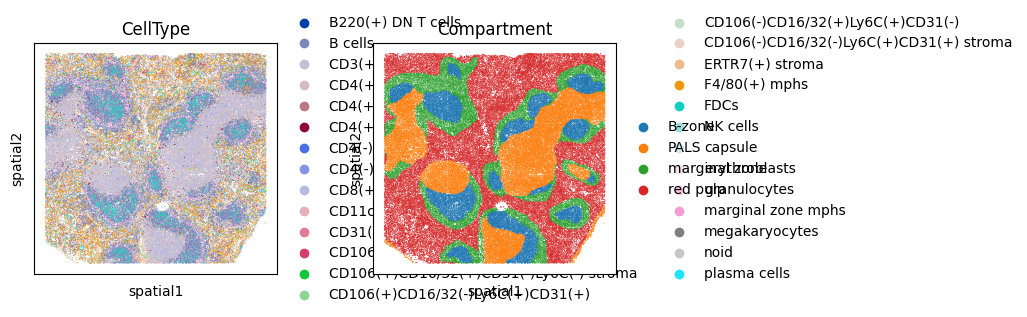

In [2]:
# download data from figshare (https://figshare.com/ndownloader/files/46669087)
# adata = sn.datasets.mouse_spleen_codex()
adata = sc.read('spleen/data/BALBc-1.h5ad')

plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata, basis="spatial", color=['CellType', 'Compartment', ],s=2, show=False, )

In [3]:
k_cutoff = 30
target_num = 4
batch_num = 30
lr = 0.01
epochs = 200

# prepare
sc.pp.scale(adata)
adata = sn.pp.cal_spatial_neighbors(adata=adata, celltype_key='CellType', mode='KNN', k_cutoff=k_cutoff, verbose=False)
adata = sn.pp.cal_spatial_exp(adata=adata, mode='KNN', k_cutoff=k_cutoff, is_pca=False, verbose=False)
adata = sn.pp.prepare_data_batch(adata=adata, verbose=False, batch_num=batch_num)
    
# training
model = sn.tr.Runner_batch(adata=adata, device='cuda:0', verbose=False)
adata = model.fit(lr=lr, epochs=epochs)
        
# clustering
adata = sn.tr.clustering(adata=adata, target_k=target_num)

100%|██████████| 30/30 [00:03<00:00,  9.26it/s]


[<AxesSubplot: title={'center': 'CellType'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot: title={'center': 'Compartment'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot: title={'center': 'scNiche'}, xlabel='spatial1', ylabel='spatial2'>]

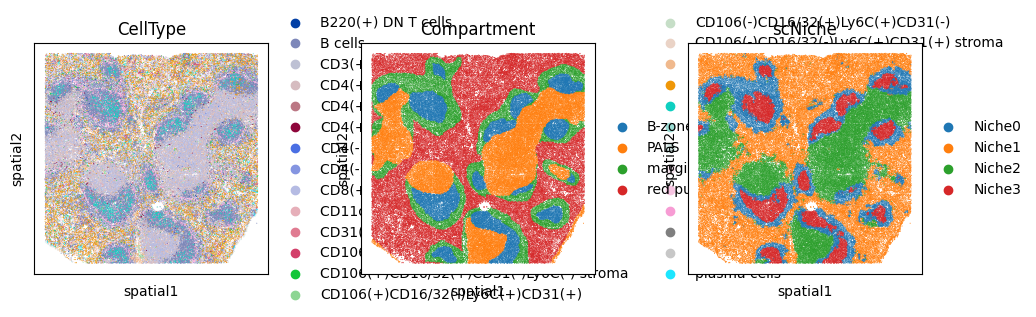

In [4]:
sc.pl.embedding(adata, basis="spatial", color=['CellType', 'Compartment', 'scNiche'],s=2, show=False, )

In [5]:
adjusted_rand_score(adata.obs['Compartment'], adata.obs['scNiche'])

0.6334245123062432